## Setup

Import the basic libraries.

In [1]:
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display
import os
%matplotlib inline

Initialize the environment for running the experiment.

In [2]:
# Paths for loading/storing results.
name = 'results/MixedGaussian_MINEE_MINE' # filename
chkpt_name = name+'.pt'              # checkpoint
fig_name = name+'.pdf'               # output figure

# use GPU if available
if torch.cuda.is_available(): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

# initialize random seed
np.random.seed(0)
torch.manual_seed(0);

## Data

Generate data using the mixed gaussian model.

In [3]:
from data.mix_gaussian import MixedGaussian

In [4]:
sample_size = 400   # sample size
rho = 0.9           # model parameter

rep = 1             # number of repeated runs
d = 1               # number of dimensions for X (and Y)

X = np.zeros((rep,sample_size,d))
Y = np.zeros((rep,sample_size,d))
mg = MixedGaussian(sample_size=sample_size,rho1=rho,rho2=-rho)
for i in range(rep):
    for j in range(d):
        data = mg.data
        X[i,:,j] = data[:,0]
        Y[i,:,j] = data[:,1]

A plot of the first dimension of $Y$ against that of $X$.

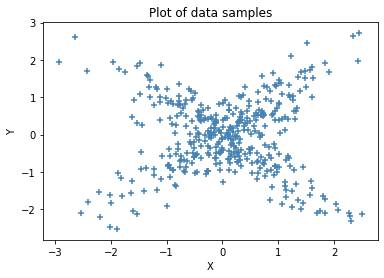

In [5]:
plt.scatter(X[0,:,0],Y[0,:,0],label="data",marker="+",color="steelblue")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of data samples')
plt.show()

## Model

Initialize the MINEE model.

In [6]:
from model.minee_mine import MINEE_MINE 

In [7]:
batch_size = 100       # batch size of data sample
ref_batch_factor = 10  # batch size expansion factor for reference sample
lr = 1e-4              # learning rate

minee_mine_list = []
for i in range(rep):
    minee_mine_list.append(MINEE_MINE(torch.Tensor(X[i]),torch.Tensor(Y[i]),
                            batch_size=batch_size,ref_batch_factor=ref_batch_factor,lr=lr))
dXY_list = np.zeros((rep,0))
dX_list = np.zeros((rep,0))
dY_list = np.zeros((rep,0))
mine_dXY_list = np.zeros((rep,0))
mi_list = np.zeros((rep,0))

Load previous results.

In [8]:
load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    dXY_list = checkpoint['dXY_list']
    dX_list = checkpoint['dX_list']
    dY_list = checkpoint['dY_list']
    mine_dXY_list = checkpoint['mine_dXY_list']
    mi_list = checkpoint['mi_list']
    minee_mine_state_list = checkpoint['minee_mine_state_list']
    for i in range(rep):
        minee_mine_list[i].load_state_dict(minee_mine_state_list[i])
    print('Previous results loaded.')

Continuously train the model with MINEE. The following can be executed repeatedly and after loading previous results.

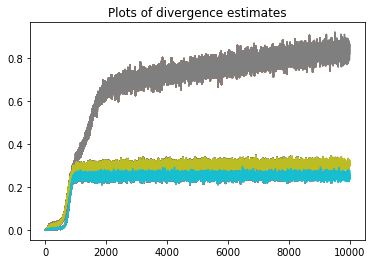

In [9]:
continue_train = True  # set to True to continue to train
num_big_steps = 50     # number of small steps
num_small_steps = 200  # number of big steps
if continue_train:
    for k in range(num_big_steps):
        for j in range(num_small_steps):
            dXY_list = np.append(dXY_list, np.zeros((rep, 1)), axis=1)
            dX_list = np.append(dX_list, np.zeros((rep, 1)), axis=1)
            dY_list = np.append(dY_list, np.zeros((rep, 1)), axis=1)
            mi_list = np.append(mi_list, np.zeros((rep, 1)), axis=1)
            for i in range(rep):
                minee_mine_list[i].step_minee()
                dXY_list[i, -1], dX_list[i, -1], dY_list[i, -1] = minee_mine_list[i].forward_minee()
                mi_list[i, -1] = (dXY_list[i, -1]-dX_list[i, -1]-dY_list[i, -1]).copy()
        # To show intermediate works
        for i in range(rep):
            plt.plot(dXY_list[i, :],label='dXY')
            plt.plot(dX_list[i, :],label='dX')
            plt.plot(dY_list[i, :],label='dY')
            plt.title('Plots of divergence estimates')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()

Continuously train the model with MINE. The following can be executed repeatedly and after loading previous results.

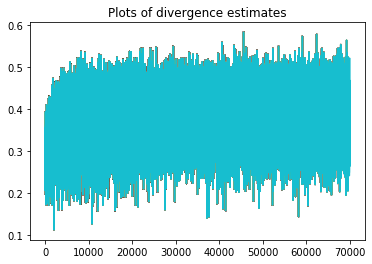

In [10]:
continue_train = True  # set to True to continue to train
num_big_steps = 350     # number of small steps
num_small_steps = 200  # number of big steps
if continue_train:
    for k in range(num_big_steps):
        for j in range(num_small_steps):
            mine_dXY_list = np.append(mine_dXY_list, np.zeros((rep, 1)), axis=1)
            mi_list = np.append(mi_list, np.zeros((rep, 1)), axis=1)
            for i in range(rep):
                minee_mine_list[i].step_mine()
                mine_dXY_list[i,-1] = minee_mine_list[i].forward_mine()
                mi_list[i,-1] = mine_dXY_list[i, -1].copy()
        # To show intermediate works
        for i in range(rep):
            plt.plot(mine_dXY_list[i, :],label='dXY')
            plt.title('Plots of divergence estimates')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()

###### Save current results.

In [11]:
overwrite = False  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    minee_mine_state_list = [minee_mine_list[i].state_dict() for i in range(rep)]
    torch.save({
        'dXY_list': dXY_list,
        'dX_list': dX_list,
        'dY_list': dY_list,
        'mine_dXY_list': mine_dXY_list,
        'mi_list': mi_list,
        'minee_mine_state_list': minee_mine_state_list
    }, chkpt_name)
    print('Current results saved.')

Current results saved.


## Analysis

Calculate the ground truth mutual information.

In [12]:
mi = mg.ground_truth * d
print('Ground truth is {} nats.'.format(mi))

Ground truth is 0.4084425498386879 nats.


Apply moving average to smooth out the mutual information estimate.

In [13]:
mi_ma_rate = 0.01            # rate of moving average
smooth_mi_list = mi_list
for i in range(1,smooth_mi_list.shape[1]):
    smooth_mi_list[:,i] = (1-mi_ma_rate) * smooth_mi_list[:,i-1] + mi_ma_rate * smooth_mi_list[:,i]

Plot the mutual information estimate after different number of iterations. The red dashed line shows the ground truth, and the green dotted line is the number of iterations where 90% of the ground truth is reached.

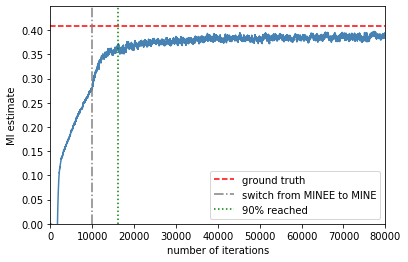

In [14]:
plt.axhline(mi,label='ground truth',linestyle='--',color='red')
for i in range(rep):
    plt.plot(smooth_mi_list[i,:],color='steelblue')
    plt.axvline(10000,label='switch from MINEE to MINE',linestyle='-.',color='gray')
    for t in range(smooth_mi_list[i].shape[0]):
        if (smooth_mi_list[0,t]>.9*mi):
            plt.axvline(t,label='90% reached',linestyle=':',color='green')
            break
#plt.title("Plot of MI estimates against number of iteractions")
plt.xlim((0,smooth_mi_list[0].shape[0]))
plt.ylim((0,mi*1.1))
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.legend()
plt.savefig(fig_name)